In [1]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
data_directory = "../Data/unh_hackathon_prompt_2_data.json"
sys.path.append("../UNH-Hackathon-2026-Group-3/")

## preparing the data


In [3]:
def load_predictive_warfighting_data(file_path: str = "unh_hackathon_prompt_2_data.json") -> pd.DataFrame:
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_json(file_path)

dirty_df = load_predictive_warfighting_data(data_directory)

# print data types of each column
# print(dirty_df.dtypes)

In [4]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the DataFrame by converting data types."""

    # Convert the string "NULL" to pd.NA
    df = df.replace("NULL", pd.NA)
    df = df.replace("N/A", pd.NA)

    for numeric_string_column in [
        "Enemy.Capability.Index",
        "EW_Capability",
        "Intel Confidence",

    ]:
        df[numeric_string_column] = pd.to_numeric(df[numeric_string_column])

    for boolean_string_column in [
        "response_success"
    ]:
        df[boolean_string_column] = df[boolean_string_column].map({"Yes": 1, "No": 0, "1": 1, "0": 0})

    return df

df = clean_data(dirty_df)

# get unique values for each string column, and min/max for each numeric column
for column in df.columns:
    if df.dtypes[column] == "str":
        print(f"Values: {df[column].drop_duplicates()}")
    else: 
        print(f"Name: {column}, dtype: {df.dtypes[column]}, min: {df[column].min()}, max: {df[column].max()}")

print(f"number of rows: {len(df)}")     
df.head()

Values: 0       Missile
2           Air
3         Cyber
4        Hybrid
7         Naval
14          AIR
35        CYBER
39       Hybrid
43          Msl
79        naval
119       Cyber
239         AIR
279         Air
299       naval
319     Missile
Name: Threat Type, dtype: str
Name: enemy_unit_count, dtype: int64, min: 1, max: 50
Name: Enemy.Capability.Index, dtype: int64, min: 1, max: 10
Name: ThreatEscalationHours, dtype: int64, min: 1, max: 72
Name: friendlyUnitCount, dtype: int64, min: 5, max: 60
Name: LCS_COUNT, dtype: int64, min: 0, max: 8
Name: Aircraft Count, dtype: int64, min: 0, max: 24
Name: cyber_defense_teams, dtype: int64, min: 0, max: 12
Name: Patriot.Batteries, dtype: int64, min: 0, max: 6
Name: ISR_AssetCount, dtype: int64, min: 0, max: 15
Name: satellite coverage score, dtype: float64, min: 0.2, max: 1.0
Name: JointForceIntegration, dtype: int64, min: 1, max: 10
Name: EW_Capability, dtype: float64, min: 0.0, max: 10.0
Name: Supply Chain Resilience, dtype: float64, min

,Threat Type,enemy_unit_count,Enemy.Capability.Index,ThreatEscalationHours,friendlyUnitCount,LCS_COUNT,Aircraft Count,cyber_defense_teams,Patriot.Batteries,ISR_AssetCount,...,CMD_COORD_SCORE,roe_complexity_score,Operational Budget (MUSD),BudgetUtilization_pct,Weather_Severity,Theater Distance KM,Season,response_success,Financial_Loss_MUSD,actual_days_to_stabilization
0,Missile,25,8,34,21,0,0,0,4,12,...,7,3,98,84,3,5164.8,Winter,1,388,10.1
1,Missile,3,2,8,45,0,0,0,4,4,...,9,5,189,97,1,7149.7,Fall,1,244,2.0
2,Air,7,3,48,45,0,5,0,0,14,...,9,1,92,88,0,6706.5,Winter,1,280,2.0
3,Cyber,31,7,70,57,0,0,7,0,5,...,10,3,314,86,9,1851.9,Fall,1,330,5.3
4,Hybrid,14,5,27,57,0,0,0,0,10,...,6,4,290,84,4,983.7,Spring,1,240,11.0


In [5]:
# get count of rows for each threat type 
threat_type_counts = df["Threat Type"].value_counts()
threat_type_counts

Threat Type
Naval       741
Air         684
Hybrid      557
Cyber       425
Missile     408
AIR          42
CYBER        32
Msl          21
 naval       19
 Hybrid      15
naval        15
 Cyber       13
 Missile     13
 Air         10
 AIR          5
Name: count, dtype: int64

In [6]:
# combine "Naval", "  naval", and "naval" into same category 
df["Threat Type"] = df["Threat Type"].str.strip()  # Remove leading/trailing whitespace
df["Threat Type"] = df["Threat Type"].str.lower()  # Convert to lowercase for consistency

# combine missile and msl into same threat type 
df["Threat Type"] = df["Threat Type"].replace({"msl": "missile"})

threat_type_counts = df["Threat Type"].value_counts()
threat_type_counts


Threat Type
naval      775
air        741
hybrid     572
cyber      470
missile    442
Name: count, dtype: int64

In [7]:
# filter by threat type here 
# df = df[df["Threat Type"] == "air"]

In [8]:
# remove rows with nan values in any column 
df = df.dropna()
len(df)

2945

In [9]:
# get array of values for input variables:
''' 
every column except output/results and categorical variables 
- also remove columns with nan values 
'''
input_columns = df.select_dtypes(include=[np.number]).columns.tolist()
input_columns.remove('response_success')
input_columns.remove('Financial_Loss_MUSD')
input_columns.remove('actual_days_to_stabilization')
input_columns = [col for col in input_columns if not df[col].isna().any()]
inputs = df[input_columns].values


# get array of values for output variables:
'''
response_success, dtype: int64
Financial_Loss_MUSD, dtype: int64
actual_days_to_stabilization, dtype: float64
'''
response_successes = df['response_success'].values
financial_loss_musds = df['Financial_Loss_MUSD'].values
actual_days_to_stabilizations = df['actual_days_to_stabilization'].values

output = financial_loss_musds

len(inputs[0]), inputs[0:3], output[0:3]

(24,
 array([[2.5000e+01, 8.0000e+00, 3.4000e+01, 2.1000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 1.2000e+01, 5.9000e-01,
         3.0000e+00, 2.0000e+00, 4.9000e-01, 1.8000e+01, 6.9000e+01,
         8.2000e-01, 2.9000e+01, 2.4000e+01, 7.0000e+00, 3.0000e+00,
         9.8000e+01, 8.4000e+01, 3.0000e+00, 5.1648e+03],
        [3.0000e+00, 2.0000e+00, 8.0000e+00, 4.5000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00, 5.5000e-01,
         9.0000e+00, 6.0000e+00, 9.4000e-01, 1.3000e+01, 6.2000e+01,
         8.5000e-01, 4.7000e+01, 7.0000e+00, 9.0000e+00, 5.0000e+00,
         1.8900e+02, 9.7000e+01, 1.0000e+00, 7.1497e+03],
        [7.0000e+00, 3.0000e+00, 4.8000e+01, 4.5000e+01, 0.0000e+00,
         5.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01, 8.8000e-01,
         3.0000e+00, 1.0000e+00, 6.3000e-01, 2.0000e+00, 1.0000e+02,
         8.1000e-01, 3.6000e+01, 3.0000e+00, 9.0000e+00, 1.0000e+00,
         9.2000e+01, 8.8000e+01, 0.0000e+00, 6.7065

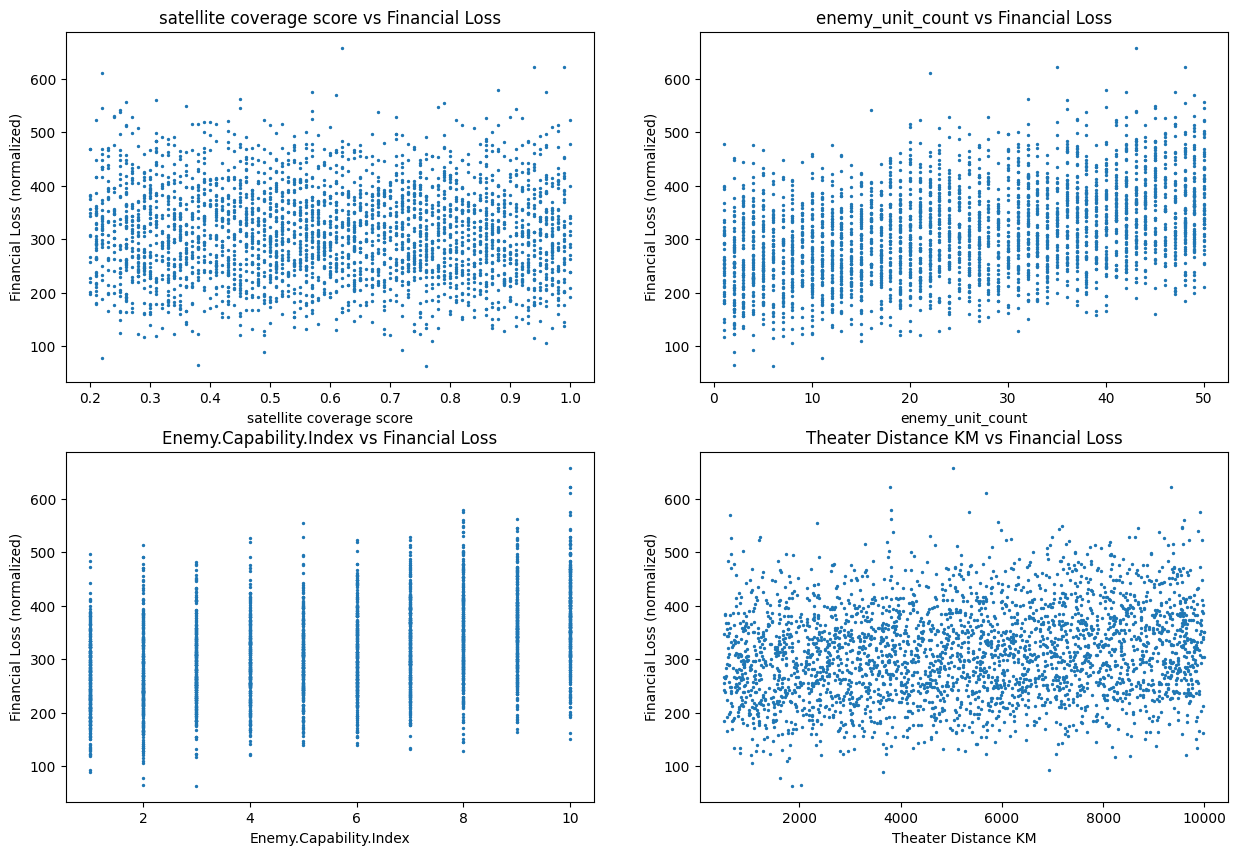

In [10]:
# plot input vs output for some input variables
input_names = [
    'satellite coverage score',
    'enemy_unit_count',
    'Enemy.Capability.Index',
    'Theater Distance KM'
]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(df[input_names[i]], output, s=2)
    ax.set_xlabel(input_names[i])
    ax.set_ylabel("Financial Loss (normalized)")
    ax.set_title(f"{input_names[i]} vs Financial Loss")


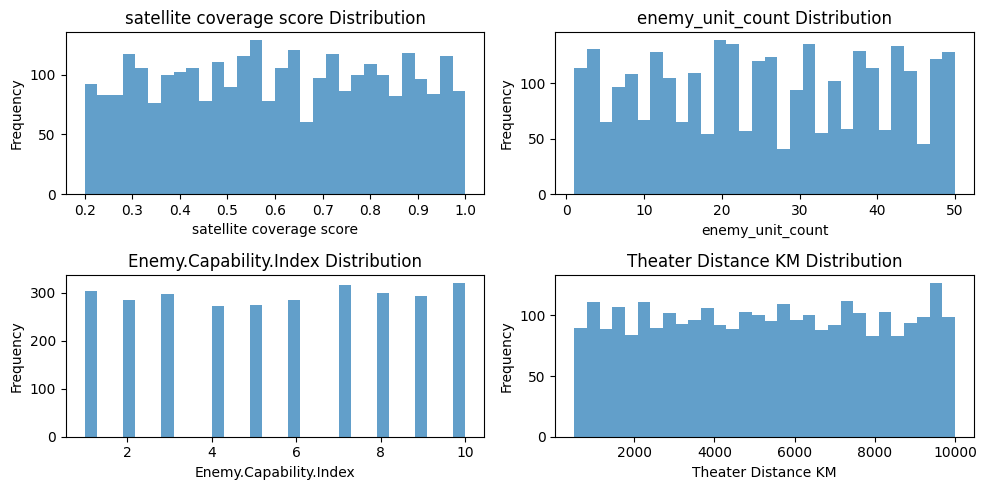

In [11]:
# histogram for some input variables
input_names = [
    'satellite coverage score',
    'enemy_unit_count',
    'Enemy.Capability.Index',
    'Theater Distance KM'
]
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(df[input_names[i]], bins=30, alpha=0.7)
    ax.set_xlabel(input_names[i])
    ax.set_ylabel("Frequency")
    ax.set_title(f"{input_names[i]} Distribution")

plt.tight_layout()
plt.show()

## preparing + running the model to predict financial loss

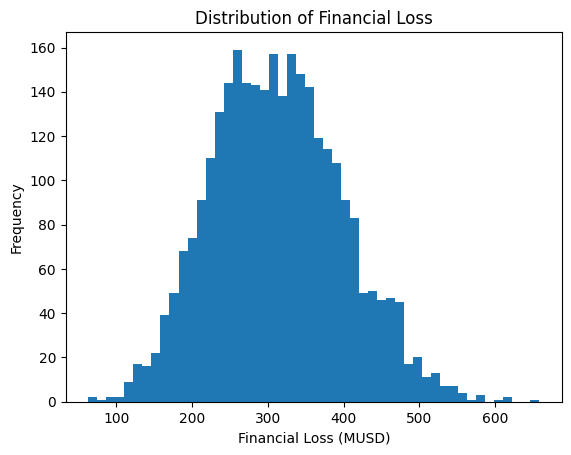

In [12]:
# visualize the distribution 
plt.hist(financial_loss_musds, bins=50)
plt.xlabel("Financial Loss (MUSD)")
plt.ylabel("Frequency")
plt.title("Distribution of Financial Loss")
plt.show()

In [13]:
# scikit learn train test split implementation 
inputs_train, inputs_test, output_train, output_test = train_test_split(
    inputs, output, test_size=0.2, random_state=42)

inputs_train[0], output_train[0]

(array([3.0000e+01, 5.0000e+00, 2.9000e+01, 5.7000e+01, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+01, 5.7000e-01,
        1.0000e+00, 5.0000e+00, 4.4000e-01, 2.4000e+01, 8.1000e+01,
        9.7000e-01, 4.5000e+01, 1.0000e+00, 1.0000e+01, 3.0000e+00,
        5.4000e+01, 8.3000e+01, 0.0000e+00, 5.2534e+03]),
 np.int64(296))

In [14]:
# standardize 
train_input_means = np.mean(inputs_train, axis=0)
train_input_stds = np.std(inputs_train, axis=0)
inputs_train = (inputs_train - train_input_means) / (train_input_stds + 1e-8)
inputs_test = (inputs_test - train_input_means) / (train_input_stds + 1e-8)

train_output_mean = np.mean(output_train)
train_output_std = np.std(output_train)
output_train = (output_train - train_output_mean) / (train_output_std + 1e-8)
output_test = (output_test - train_output_mean) / (train_output_std + 1e-8)

inputs_train[0], output_train[0]

(array([ 0.30668271, -0.19667566, -0.39783589,  1.53510575, -0.47909972,
        -0.49471853,  0.37837363, -0.33682718,  0.60204725, -0.14561976,
        -1.58130083, -0.044019  , -1.48553301,  1.50385373,  0.62057173,
         1.60341588,  1.46994105, -1.58287932,  1.56033253,  0.0205849 ,
        -1.65892897,  0.26791034, -1.57632656, -0.00176667]),
 np.float64(-0.1925269864168591))

# linear regression

In [15]:
torch.Tensor(inputs_train)[0]

tensor([ 0.3067, -0.1967, -0.3978,  1.5351, -0.4791, -0.4947,  0.3784, -0.3368,
         0.6020, -0.1456, -1.5813, -0.0440, -1.4855,  1.5039,  0.6206,  1.6034,
         1.4699, -1.5829,  1.5603,  0.0206, -1.6589,  0.2679, -1.5763, -0.0018])

In [16]:
# linear regression model 
class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(len(inputs[0]), 1)  # One in and one out

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
linearmodel = LinearRegressionModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(linearmodel.parameters(), lr=0.01)

for epoch in range(500):

    # Forward pass: Compute predicted y by passing 
    # x to the model
    pred_y = linearmodel(torch.Tensor(inputs_train))

    # Compute and print loss
    loss = criterion(pred_y, torch.Tensor(output_train))

    # Zero gradients, perform a backward pass, 
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([2356])) that is different to the input size (torch.Size([2356, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 1.4311543703079224
epoch 1, loss 1.4139559268951416
epoch 2, loss 1.3974578380584717
epoch 3, loss 1.3816310167312622
epoch 4, loss 1.3664472103118896
epoch 5, loss 1.3518801927566528
epoch 6, loss 1.3379039764404297
epoch 7, loss 1.324494481086731
epoch 8, loss 1.311627984046936
epoch 9, loss 1.2992820739746094
epoch 10, loss 1.287435531616211
epoch 11, loss 1.2760673761367798
epoch 12, loss 1.2651580572128296
epoch 13, loss 1.2546883821487427
epoch 14, loss 1.2446407079696655
epoch 15, loss 1.2349973917007446
epoch 16, loss 1.2257421016693115
epoch 17, loss 1.2168585062026978
epoch 18, loss 1.2083317041397095
epoch 19, loss 1.2001469135284424
epoch 20, loss 1.192290186882019
epoch 21, loss 1.1847479343414307
epoch 22, loss 1.1775076389312744
epoch 23, loss 1.170556664466858
epoch 24, loss 1.1638834476470947
epoch 25, loss 1.157476544380188
epoch 26, loss 1.1513252258300781
epoch 27, loss 1.1454188823699951
epoch 28, loss 1.1397477388381958
epoch 29, loss 1.1343021392822

# torch.nn 

In [17]:
class NNmodel(nn.Module):
    def __init__ (self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(inputs_train[0]), 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)

        )

    def forward(self, x):
        # logits = self.linear_relu_stack(x)
        return self.linear_relu_stack(x)
    
class AbsDataset(Dataset):
    def __init__ (self, inputs, output):
        self.input_tensor = torch.tensor(inputs).float() 
        self.output_tensor = torch.tensor(output).float()
        
    def __len__(self):
        return len(self.output_tensor)
    
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx] 

In [18]:
train_dataset = AbsDataset(inputs_train, output_train)
test_dataset = AbsDataset(inputs_test, output_test)

# shuffles and batches 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# initiate model
nnmodel = NNmodel()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(nnmodel.parameters(), lr=0.001) # learning rate


In [19]:
# training with per-epoch testing
training_loss_ls = []
test_loss_ls = []

epochs = 100

for epoch in range(epochs):
    epoch_loss_ls = []
    print("epoch #:", epoch)

    # training loop 
    nnmodel.train()
    for data, labels in train_loader:
        optimizer.zero_grad() # resets gradients in optimizer to 0 
        outputs = nnmodel(data)

        # calculate loss function (MSE)
        loss = loss_func(outputs, labels.unsqueeze(1))
        epoch_loss_ls.append(loss.item())
        loss.backward() # back prop 

        # optimizer 
        optimizer.step() # updates all parameters via gradient descent 
        
    avg_loss = np.average(np.array(epoch_loss_ls))
    print("average training loss:", avg_loss)
    training_loss_ls.append(avg_loss)
    
    # testing loop per epoch
    nnmodel.eval()
    test_epoch_ls = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = nnmodel(data)
            loss = loss_func(outputs, labels)
            test_epoch_ls.append(loss.item())
    
    avg_test_loss = np.average(np.array(test_epoch_ls))
    print("average test loss:", avg_test_loss)
    test_loss_ls.append(avg_test_loss)

epoch #: 0


average training loss: 0.611795541402456
average test loss: 0.21301213648840184
epoch #: 1
average training loss: 0.2456810321356799


/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


average test loss: 0.1517645689995999
epoch #: 2
average training loss: 0.2024078844366847
average test loss: 0.13296180220062193
epoch #: 3
average training loss: 0.16721985891864105
average test loss: 0.13112936863749658
epoch #: 4
average training loss: 0.14844426633538427
average test loss: 0.12202437439553002
epoch #: 5
average training loss: 0.1446474486508885
average test loss: 0.11555407292329677
epoch #: 6
average training loss: 0.13661598112132098
average test loss: 0.11479685882481203
epoch #: 7
average training loss: 0.1301909056869713
average test loss: 0.10825351678574274
epoch #: 8
average training loss: 0.13678646188330007
average test loss: 0.10618439347410723
epoch #: 9
average training loss: 0.12786992115748896
average test loss: 0.10816273044144223
epoch #: 10
average training loss: 0.12290655116777162
average test loss: 0.11382630100861164
epoch #: 11
average training loss: 0.13111822397725
average test loss: 0.10324153934498838
epoch #: 12
average training loss: 0

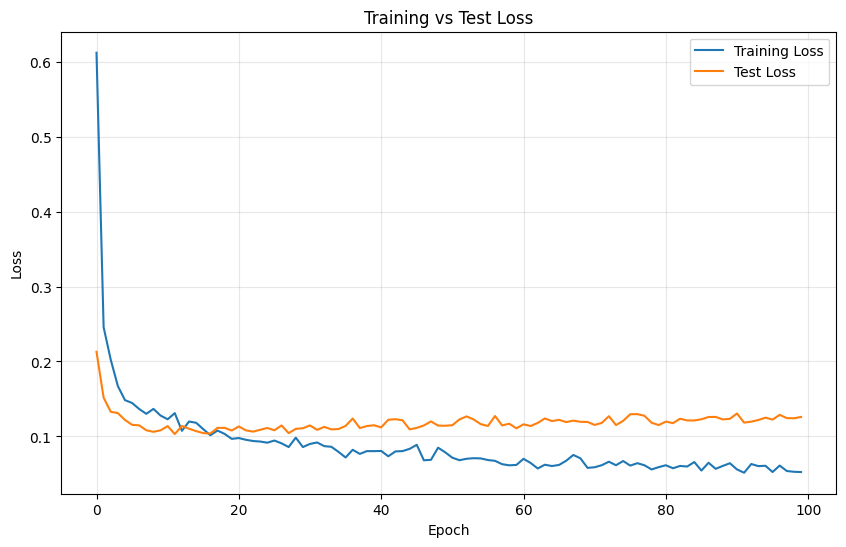

In [20]:
# Plot training and test loss together
x = range(epochs)
plt.figure(figsize=(10, 6))
plt.plot(x, training_loss_ls, label='Training Loss')
plt.plot(x, test_loss_ls, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.grid(True, alpha=0.3)
plt.show()

## visualizing model outputs 

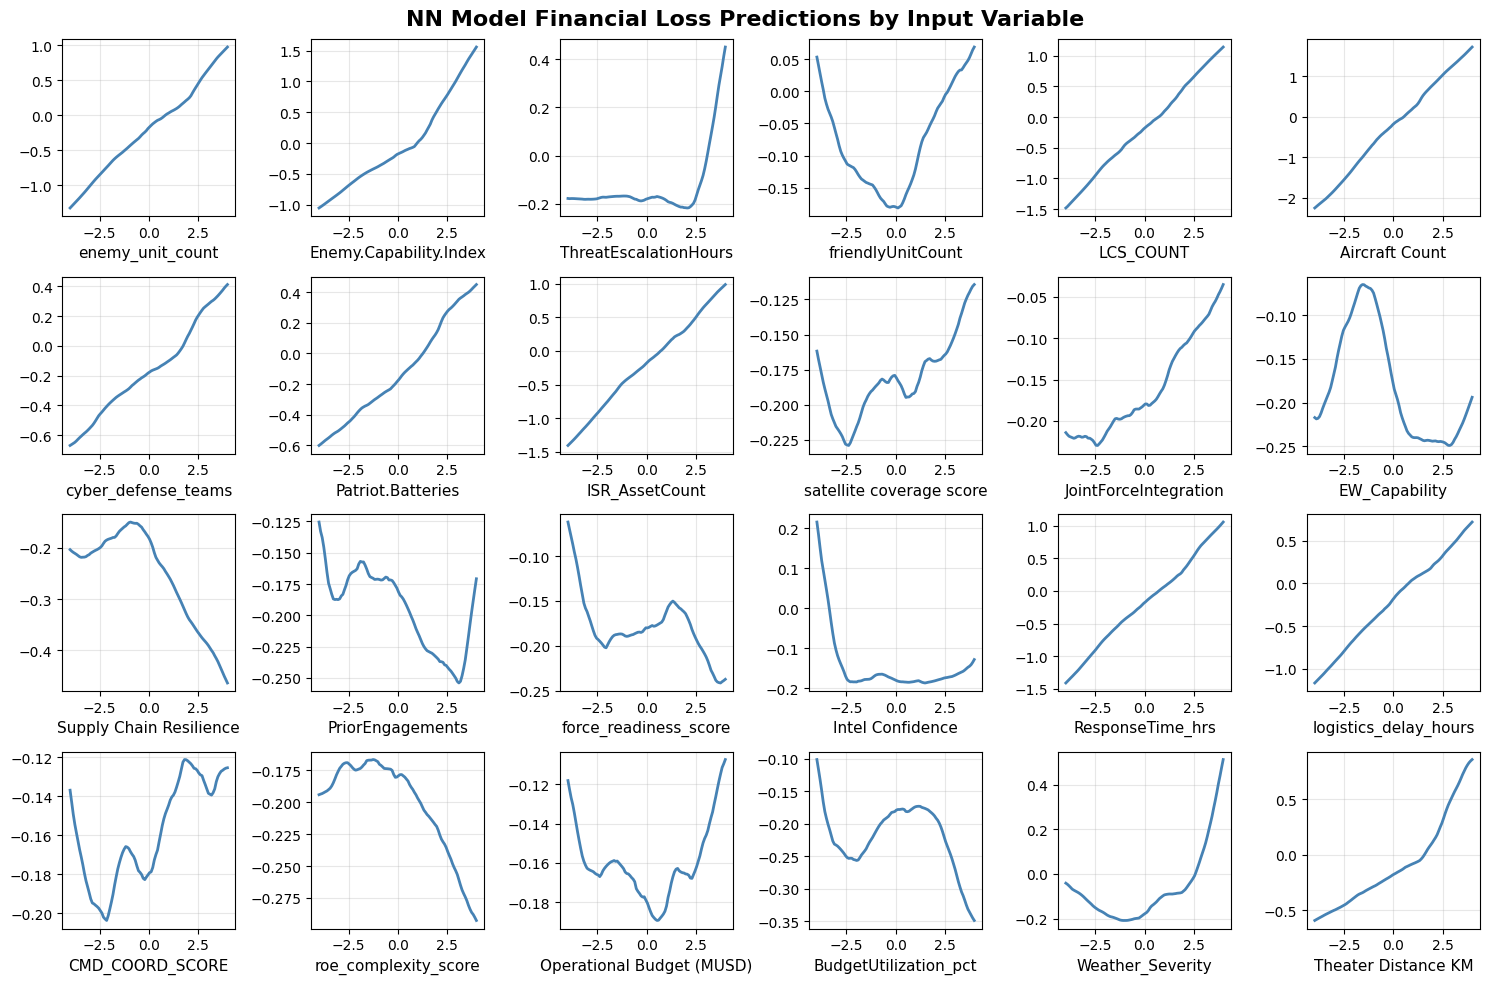

In [61]:
# Visualize nn model: 2D plots of each input vs output
nnmodel.eval() # Set model to evaluation mode

fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.flatten()

# For each input variable, create predictions while varying that input
for i, ax in enumerate(axes):
    # Create a range of values for the input variable
    input_range = np.linspace(-4, 4, 100)
    
    # Create prediction arrays by holding other inputs at their mean
    predictions = []
    
    for val in input_range:
        # Start with mean normalized values for all inputs
        input_vector = np.mean(inputs_train, axis=0) # should be around zero 
        
        # Vary the current input
        input_vector[i] = val
        
        # Convert to tensor and predict
        input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
        with torch.no_grad():
            pred = nnmodel(input_tensor).item()
        predictions.append(pred)
    
    # Plot
    ax.plot(input_range, predictions, linewidth=2, color='steelblue')
    ax.set_xlabel(input_columns[i], fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('NN Model Financial Loss Predictions by Input Variable', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

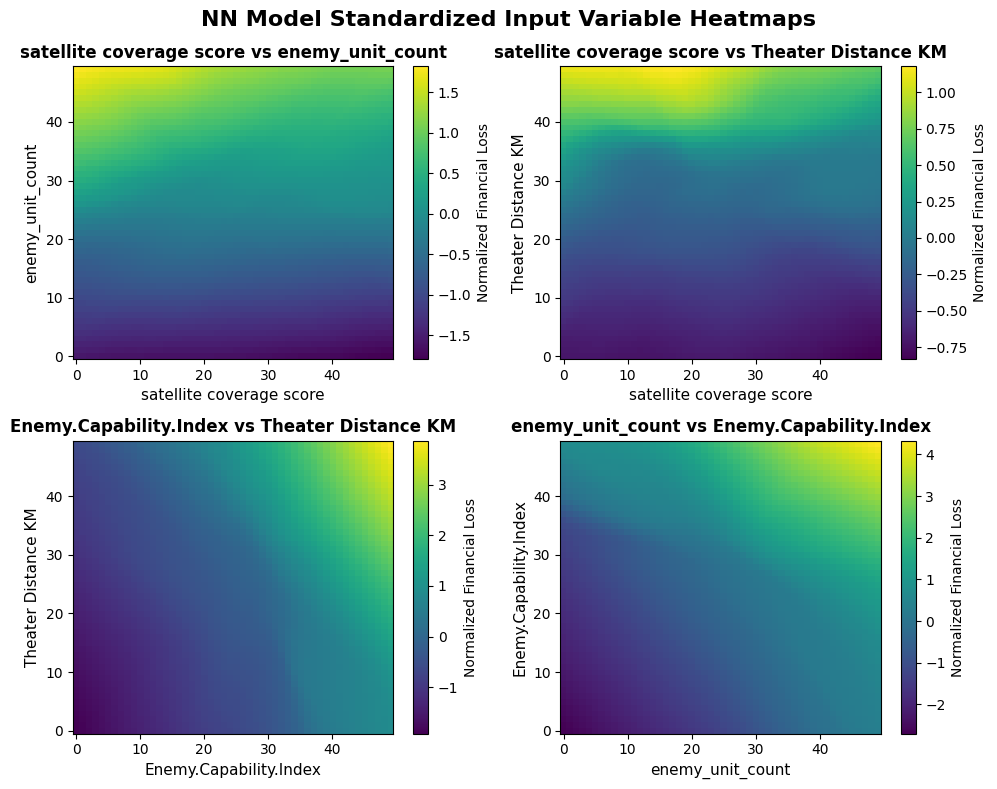

In [87]:
# Create 2D heatmaps for key input pairs
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

input_names = [
    'satellite coverage score',
    'enemy_unit_count',
    'Enemy.Capability.Index',
    'Theater Distance KM'
]

# Define pairs to visualize (most important interactions)
pairs = [(0, 1), (0, 3), (2, 3), (1, 2)]

for plot_idx, (i, j) in enumerate(pairs):
    ax = axes[plot_idx]
    
    # Create grid of values
    input_range = np.linspace(-5, 5, 50)
    heatmap = np.zeros((len(input_range), len(input_range)))
    
    # Fill heatmap by varying inputs i and j
    for x_idx, x_val in enumerate(input_range):
        for y_idx, y_val in enumerate(input_range):
            input_vector = np.mean(inputs_train, axis=0)
            input_vector[input_columns.index(input_names[i])] = x_val
            input_vector[input_columns.index(input_names[j])] = y_val
            
            input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
            with torch.no_grad():
                pred = nnmodel(input_tensor).item()
            heatmap[y_idx, x_idx] = pred
    
    # Plot heatmap with color scale
    im = ax.imshow(heatmap, aspect='auto', origin='lower', cmap='viridis')
    ax.set_xlabel(input_names[i], fontsize=11)
    ax.set_ylabel(input_names[j], fontsize=11)
    ax.set_title(f'{input_names[i]} vs {input_names[j]}', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Financial Loss')

plt.suptitle('NN Model Standardized Input Variable Heatmaps', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [35]:
# model prediction for input vector of all 0.5 values
input_vector = np.array([0.5]*24)
input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
with torch.no_grad():
    pred = nnmodel(input_tensor).item()
print(f"Model prediction for input vector {input_vector}:", pred)

# calculate mean square error on train dataset 
print(train_dataset[0])
mse = 0
for input, output in train_dataset:
    input_tensor = input.unsqueeze(0)
    with torch.no_grad():
        pred = nnmodel(input_tensor).item()
    # print(f"Model prediction: {pred}, Actual output: {output.item()}")
    mse += (pred - output.item())**2
mse /= len(train_dataset)
print(f"Mean Squared Error on train dataset: {mse}")

# calculate mean square error on test dataset 
print(test_dataset[0])
mse = 0
for input, output in test_dataset:
    input_tensor = input.unsqueeze(0)
    with torch.no_grad():
        pred = nnmodel(input_tensor).item()
    # print(f"Model prediction: {pred}, Actual output: {output.item()}")
    mse += (pred - output.item())**2
mse /= len(test_dataset)
print(f"Mean Squared Error on test dataset: {mse}")
    


Model prediction for input vector [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5]: 0.900582492351532
(tensor([ 0.3067, -0.1967, -0.3978,  1.5351, -0.4791, -0.4947,  0.3784, -0.3368,
         0.6020, -0.1456, -1.5813, -0.0440, -1.4855,  1.5039,  0.6206,  1.6034,
         1.4699, -1.5829,  1.5603,  0.0206, -1.6589,  0.2679, -1.5763, -0.0018]), tensor(-0.1925))
Mean Squared Error on train dataset: 0.01756126624875485
(tensor([ 0.0309,  0.4903, -0.0083,  1.4103, -0.4791, -0.4947, -0.3723, -0.3368,
        -1.5553, -1.4912,  0.5297, -1.3088, -1.7154,  1.6375,  0.3891, -0.0922,
        -1.0016,  1.6152,  0.8699,  0.7235,  0.8240,  0.1810, -0.6337,  0.4126]), tensor(-0.8185))
Mean Squared Error on test dataset: 0.12603058402022752


In [37]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate on entire dataset
nnmodel.eval()
all_predictions = []
all_true_values = []
# combine standardized train and test inputs and outputs into full dataset
full_inputs = np.vstack([inputs_train, inputs_test])
full_outputs = np.hstack([output_train, output_test])
full_dataset = AbsDataset(full_inputs, full_outputs)

with torch.no_grad():
    for data, labels in DataLoader(full_dataset, batch_size=32):
        outputs = nnmodel(data)
        all_predictions.extend(outputs.numpy().flatten())
        all_true_values.extend(labels.numpy().flatten())

all_predictions = np.array(all_predictions)
all_true_values = np.array(all_true_values)

# Calculate metrics
mae = mean_absolute_error(all_true_values, all_predictions)
r2 = r2_score(all_true_values, all_predictions)
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
mape = np.mean(np.abs((all_true_values - all_predictions) / all_true_values)) * 100

print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.129685
Root Mean Squared Error (RMSE): 0.198129
R² Score: 0.960794
Mean Absolute Percentage Error (MAPE): 59.98%


In [42]:
# calculate metrics on original (unstandardized) scale
all_predictions_unstd = all_predictions * (train_output_std) + train_output_mean
all_true_values_unstd = all_true_values * (train_output_std) + train_output_mean

# Calculate metrics
mae = mean_absolute_error(all_true_values_unstd, all_predictions_unstd)
r2 = r2_score(all_true_values_unstd, all_predictions_unstd)
rmse = np.sqrt(mean_squared_error(all_true_values_unstd, all_predictions_unstd))
mape = np.mean(np.abs((all_true_values_unstd - all_predictions_unstd) / all_true_values_unstd)) * 100

print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 11.186909
Root Mean Squared Error (RMSE): 17.091059
R² Score: 0.960794
Mean Absolute Percentage Error (MAPE): 3.69%


In [43]:
train_input_means[0]

np.float64(25.551782682512734)

In [ ]:
# plots of unstandardized predictions vs unstandardized inputs 
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()


    

In [52]:
# TODO: finish last cell, map all of the standardized input variables on 4x6 axes